In [1]:
import json
import networkx as nx
import matplotlib.pyplot as plt

## node

Nodes represent 1-indexed segments of sequence (although at the moment, the positions aren't used).
Nodes have a `node_id`, a `first` position, and a `last` position using BED-style coordinates.
The first or last positions may be specified as `*` to denote that they are the first or last node in the path.
Nodes are always represented as top strand reference orientation.  `node_id` are assigned as consecutive letters in top strand reference order.

```
N node_id first last
```

In [2]:
# a complementary node is the same node on the opposite strand
def complementary_node_id(node_id):
  """Use prime to denote the opposite strand"""
  return node_id if node_id.endswith("'") else f"{node_id}'"

def minus_strand_node(node):
  """Return the node on the minus strand"""
  return {
    'node_id': complementary_node_id(node['node_id']),
    'first': node['last'],
    'last': node['first']
  }

def load_nodes_data(filename):
  with open(filename, 'r') as f:
    return json.load(f)
  
def add_nodes(G, nodes_data):
  for node in nodes_data + [minus_strand_node(_) for _ in nodes_data]:
    node_id = node['node_id']
    G.add_node(node_id, first=node['first'], last=node['last'])

## edge

Edges are connections between nodes.

```
E node_id1 node_id2 node1_exit node2_enter explicit read_support
```

- node exits are defined as where the edge "exits", either true (5', left) or false (3', right), wrt the reference orientation of the node (and always represent the first or last position of the node)
- explicit/implicit (bool) is a flag that indicates whether the edge is explicit (true) or implicit (false)
  - explicit edges pass from node to node with a discontinuity in position, i.e., the right end of node_id1 is not the same as the left end of node_id2
  - implicit edges pass from node to node without a discontinuity in position; i.e. the right end of node_id1 is directly connected to the left end of node_id2 in the same orientation
  - edges representing deletions or insertions always connect opposite ends in the same orientation
  - edges representing inversions always connect ends in opposite orientations
- read_support is the number (int) of reads supporting the edge; not using this for now, but we could eventually use it to allow an explicit edge to be traversed more than once
  - for implicit edges, read_support is the read depth at the position of the edge
  - for explicit edges, read_support is the number of reads that span the edge
- edges are bidirectional, i.e., an edge exiting node1 on the right and entering node2 on the left in the same orientation is equivalent to an edge exiting node2 on the right and entering node1 on the left in the same orientation
- paths travel from "left" to "right"

In [3]:
ENDS = {
  'LEFT': True,
  'RIGHT': False
}

def load_edges_data(filename):
  with open(filename, 'r') as f:
    return json.load(f)

def generate_implicit_edge_data(nodes_data):
  return [
    {
      'node_id1': first['node_id'],
      'node_id2': second['node_id'],
      'node1_exit': 'RIGHT',
      'node2_enter': 'LEFT',
      'explicit': False,
      'read_support': 5
    }
    for first, second in zip(nodes_data, nodes_data[1:])
  ]

def add_edges(G, edges_data):
  for edge in edges_data:
  # we're going to add the edge twice, once for each direction
  # since it's still just a single edge, we'll assign a unique id
  # use the unique_id later to require that an explicit edge is only traversed once
    unique_edge_id = f"{edge['node_id1']}_{edge['node_id2']}"
    G.add_edge(
      edge['node_id1'],
      edge['node_id2'],
      node1_exit=ENDS[edge['node1_exit']],
      node2_enter=ENDS[edge['node2_enter']],
      explicit=edge['explicit'],
      read_support=edge['read_support'],
      unique_id=unique_edge_id
    )
    G.add_edge(
      complementary_node_id(edge['node_id2']),
      complementary_node_id(edge['node_id1']),
      node1_exit=ENDS[edge['node1_exit']],
      node2_enter=ENDS[edge['node2_enter']],
      explicit=edge['explicit'],
      read_support=edge['read_support'],
      unique_id=unique_edge_id
    )


In [4]:
def plot_graph(G):
    nx.draw_networkx(
        G,
        pos=nx.planar_layout(G),
        with_labels=True,
    )
    plt.show()

def print_cycles(G):
    print("Cycles:")
    for cycle in nx.simple_cycles(G):
        print(' -> '.join(cycle))

def print_simple_paths(G, source, target):
    print("Simple paths:")
    for path in sorted(nx.all_simple_paths(G, source, target), key=lambda path: len(path)):
        print(' -> '.join(path))

In [5]:
def solve_graph(nodes_data_file_path, edges_data_file_path):
  # create graph
  G = nx.DiGraph()
  #G = nx.MultiDiGraph()

  # load node data
  nodes_data = load_nodes_data(nodes_data_file_path)
  add_nodes(G, nodes_data)

  first_node = nodes_data[0]['node_id']
  last_node = nodes_data[-1]['node_id']

  # load edge data
  explicit_edges_data = load_edges_data(edges_data_file_path)
  implicit_edges_data = generate_implicit_edge_data(nodes_data)
  add_edges(G, explicit_edges_data + implicit_edges_data)

  # plot graph
  plot_graph(G)

  # print cycles
  print_cycles(G)

  # print simple paths
  print_simple_paths(G, first_node, last_node)

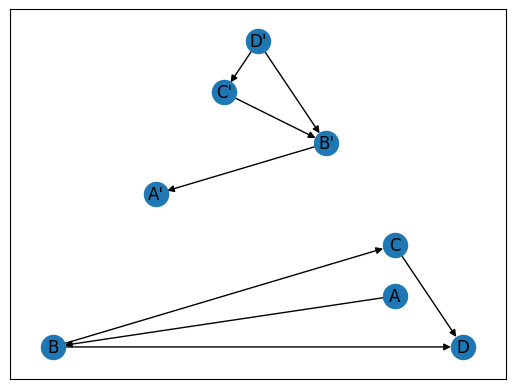

Cycles:
Simple paths:
A -> B -> D
A -> B -> C -> D


In [10]:
solve_graph('nodes/simple_nodes.json', 'edges/simple_deletion.json')
# for simple deletions, the two graphs should be disconnected because
# no explicit edges connect them
# in addition to the answer we want (ABD), we get the trivial answer ABCD
# because we haven't required that all explicit edges are traversed

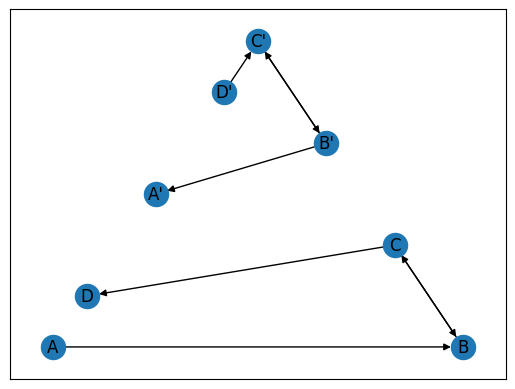

Cycles:
B' -> C'
C -> B
Simple paths:
A -> B -> C -> D


In [9]:
solve_graph('nodes/simple_nodes.json', 'edges/simple_duplication.json')
# for simple duplications, the two graphs should be disconnected because
# no explicit edges connect them
# there are bidirectional edges along the duplicated edge, leading to a cycle
# we acutally want to allow explicit edges (by their unique_id) to be traversed once and only once
# which could prevent recursion in the cycles
# we're missing the answer we want here, which is ABCBCD

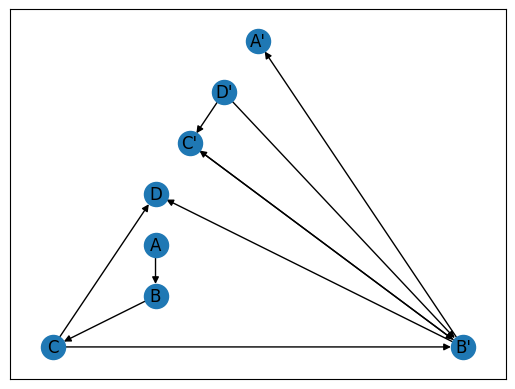

Cycles:
B' -> C'
Simple paths:
A -> B -> C -> D
A -> B -> C -> B' -> D


In [11]:
solve_graph('nodes/simple_nodes.json', 'edges/simple_inversion.json')
# inversions connect the two graphs
# the answer we want is ABCB'D
# we also get the trivial answer ABCD because we haven't required that all explicit edges are traversed

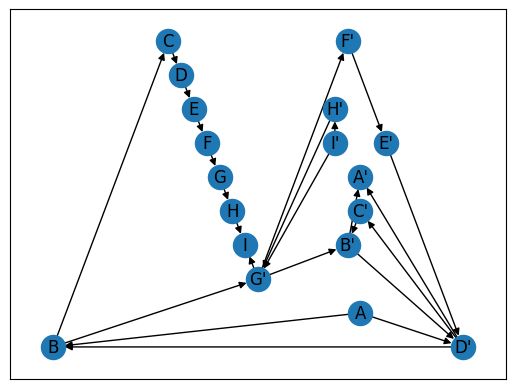

Cycles:
B -> G' -> B' -> D'
B -> G' -> F' -> E' -> D'
C' -> B' -> D'
Simple paths:
A -> B -> G' -> I
A -> D' -> B -> G' -> I
A -> B -> C -> D -> E -> F -> G -> H -> I
A -> D' -> B -> C -> D -> E -> F -> G -> H -> I


In [12]:
solve_graph('nodes/complex_nodes.json', 'edges/complex.json')
# we get the answer we want (AD'BG'I)
# but we also get several incorrect answers because we haven't required that all explicit edges are traversed
# and we also get the trivial answer ABCDEFGHI